In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import os
from kaggle import KaggleApi

In [ ]:


# Instantiate Kaggle API
api = KaggleApi()
api.authenticate()

# Download and extract population dataset
dataset = "thedevastator/u-s-public-debt-vs-gdp-from-1947-2020"
folder = 'data'
try:
    api.dataset_download_files(dataset, path=folder, unzip=True)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    exit(1)

dataset = "alfredkondoro/u-s-economic-indicators-1974-2024"
folder = 'data'
try:
    api.dataset_download_files(dataset, path=folder, unzip=True)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    exit(1)

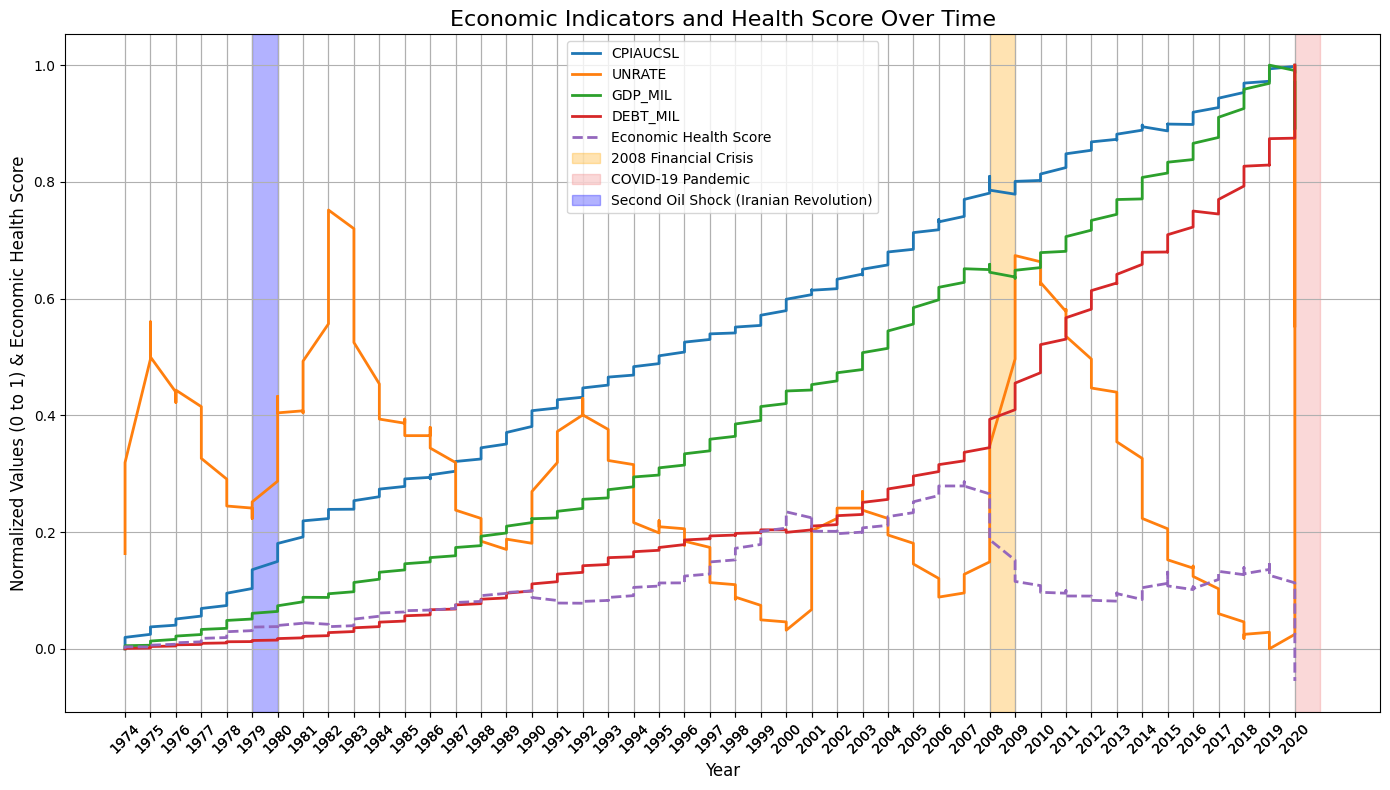

In [27]:
# # Step 1: Read and preprocess the datasets
cpi_data = pd.read_csv("data/cpi_data.csv")
gdp_data = pd.read_csv("data/gdp_data.csv")
unemployment_data = pd.read_csv("data/unemployment_data.csv")
us_gdp_debt = pd.read_csv("data/US GDP vs Debt.csv")

# Ensure consistent column names
cpi_data.columns = ["DATE", "CPIAUCSL"]
gdp_data.columns = ["DATE", "GDP"]
unemployment_data.columns = ["DATE", "UNRATE"]
us_gdp_debt.columns = ["index","Quarter", "Gross Domestic Product ($mil)", "Total Public Debt ($mil)"]

# # Step 2 :  Converting Date Columns to Datetime Format
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
us_gdp_debt['Quarter'] = pd.to_datetime(us_gdp_debt['Quarter'])

# # Step 3: Converting Monthly Data to Quarterly Data

# CPI
cpi_data['Quarter'] = cpi_data['DATE'].dt.to_period('Q')
cpi_quarterly = cpi_data.groupby('Quarter')['CPIAUCSL'].mean().reset_index()

# GDP Quarter
gdp_data['Quarter'] = gdp_data['DATE'].dt.to_period('Q')
gdp_quarterly = gdp_data.groupby('Quarter')['GDP'].mean().reset_index()

# unemployment Quarter
unemployment_data['Quarter'] = unemployment_data['DATE'].dt.to_period('Q')
unemployment_quarterly = unemployment_data.groupby('Quarter')['UNRATE'].mean().reset_index()

# # Step 4: Merge the datasets
# Merge CPI, GDP, and Unemployment data on Quarter
merged_quarterly = cpi_quarterly.merge(unemployment_quarterly, on='Quarter', how='inner')
merged_quarterly = merged_quarterly.merge(gdp_quarterly, on='Quarter', how='inner')

# Merge with Debt data
us_gdp_debt.rename(columns={
    'Gross Domestic Product ($mil)': 'GDP_MIL',
    'Total Public Debt ($mil)': 'DEBT_MIL'
}, inplace=True)
us_gdp_debt['Quarter'] = us_gdp_debt['Quarter'].dt.to_period('Q')

# Save the final combined dataset
# final = merged_quarterly.merge(us_gdp_debt, on='Quarter', how='inner')
# final.to_csv("data/final_combined_quarterly_data.csv", index=False)
# print("Final combined dataset saved as 'final_combined_quarterly_data.csv'.")

final_data = pd.read_csv("data/final_combined_quarterly_data.csv")
# # Step 5: Yearly aggregation
final_data['Year'] = final_data['Quarter'].str[:4].astype(int)


annual_data = final_data.groupby('Year').sum().reset_index()
normalized_data = final_data.copy()
columns_to_normalize = ['CPIAUCSL', 'UNRATE', 'GDP_MIL', 'DEBT_MIL']



# # Step 6 : Analysys 01 - Economic Events Analysis:
# Highlight significant periods like recessions (e.g., 2008, 2020).
# Assess their impact on GDP, inflation, unemployment, and debt.

import matplotlib.pyplot as plt

# Normalized data for economic indicators
for col in ['CPIAUCSL', 'UNRATE', 'GDP_MIL', 'DEBT_MIL']:
    normalized_data[col] = (final_data[col] - final_data[col].min()) / (final_data[col].max() - final_data[col].min())

# Calculate Economic Health Score
normalized_data['Economic_Health_Score'] = (normalized_data['GDP_MIL'] - normalized_data['DEBT_MIL']) / (normalized_data['UNRATE'] + 1)

# Create combined plot
plt.figure(figsize=(14, 8))

# Plot normalized economic indicators
for col in ['CPIAUCSL', 'UNRATE', 'GDP_MIL', 'DEBT_MIL']:
    plt.plot(final_data['Year'], normalized_data[col], label=col, linewidth=2)

# Plot Economic Health Score
plt.plot(final_data['Year'], normalized_data['Economic_Health_Score'], label='Economic Health Score', linewidth=2, linestyle='--')

# Highlight events using shaded regions with custom colors
events = {
    "2008 Financial Crisis": (2008, 2009, 'orange'),
    "COVID-19 Pandemic": (2020, 2021, 'lightcoral'),
    "Second Oil Shock (Iranian Revolution)": (1979,1980, 'blue')
}

for event, (start, end, color) in events.items():
    plt.axvspan(start, end, color=color, alpha=0.3, label=f"{event}")

# Add labels, title, and legend
plt.title("Economic Indicators and Health Score Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Values (0 to 1) & Economic Health Score", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.xticks(ticks=final_data['Year'][::2], labels=final_data['Year'][::2], rotation=45)

# Show the combined plot
plt.tight_layout()
plt.show()
